In [1]:
# 기술 출처 : towards Context-aware Automatic Haptic  Effect Generation for Home Theatre Environments

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# bark 계산
def get_bark_from_freq(freq: int):
    return 7 * np.arcsinh(freq / 600)

# freq 계산
def get_freq_from_bark(bark: float):
    return 600 * np.sinh(bark / 7)

print(get_freq_from_bark(0.3)) # 25.722158157347017
print(get_freq_from_bark(24)) # 9240.039453276086
print(get_freq_from_bark(0.49529)) # 42.488860375848695

print(get_bark_from_freq(26)) # 0.30323848136264453
print(get_bark_from_freq(9240)) # 23.9999701740334
print(get_bark_from_freq(43)) # 0.5012382202199146
# 26 ~ 9240 hz 사용

# A-weighting 출력 시도 (테스트)
freq_bins = [100, 300, 500, 1000, 10000]
a_weighting = librosa.A_weighting(freq_bins)
print(a_weighting)

25.722158157347017
9240.039453276086
42.488860375848695
0.30323848136264453
23.9999701740334
0.5012382202199146
[-1.91424325e+01 -7.05364105e+00 -3.24733157e+00  3.44464746e-04
 -2.49144227e+00]


In [3]:
# adaptive threshold algorithm
def get_adaptive_threshold(values, sr: int = 44100, n_fft: int = 2048, multiple: float = 3, time_in_seconds: float = 10):
    index = int(time_in_seconds * sr / (n_fft // 4))
    thresholds = np.array([ (sum(values[i-index+1:i]) if i-index+1 >= 0 else sum(list(values[i-index+1:]) + list(values[:i]))) / index for i in range(0, len(values)) ]) \
               + multiple * np.array([ (np.std(values[i-index+1:i]) if i-index+1 >= 0 else np.std(list(values[i-index+1:]) + list(values[:i]))) for i in range(0, len(values))])
    return thresholds

In [4]:
# 변환된 프레임을 바탕으로 타임스탬프 값 구하기
def get_time_from_index(index: int, sr: int = 44100, n_fft: int = 2048):
    hop_length = n_fft // 4
    return index * hop_length / sr

# 타임스탬프를 바탕으로 프레임 인덱스 구하기
def get_index_from_time(time: float, sr: int = 44100, n_fft: int = 2048):
    hop_length = n_fft // 4
    return int(time / hop_length * sr)

In [5]:
# 진동 타입에 대하여 정의하는 함수
def get_haptic_type(cognition_ratio):
    types = [ "default", "sharp", "staccato" ] # examples
    return types[0]

# 진동 세기에 대하여 정의하는 함수 (0 ~ 1)
def get_haptic_level(cognition_result, cognition_ratio):
    return 1

In [6]:
file_name = os.path.join("demo", "test1.mp3")

sample_rate = 44100
start_sec = 0
end_sec = -1 # -1 는 끝까지 / 원하는 부분의 초 타임스탬프를 입력 (ex. 3초면 3)
max_amplitude = 1.0
min_amplitude = -1.0

audio, _ = librosa.load(file_name, sr=sample_rate)
if end_sec == -1: # full
    audio = audio[(sample_rate*start_sec):]
else:
    audio = audio[(sample_rate*start_sec):(sample_rate*end_sec)]

max_value = np.max(np.abs(audio))

if max_value > 0 :
    audio = audio * (max_amplitude / max_value)

print(audio.shape)
print(int(audio.shape[0]) / sample_rate)

(4492288,)
101.8659410430839


[0.0000000e+00 0.0000000e+00 8.4320757e-26 ... 1.5556260e-17 2.2682434e-22
 2.3224391e-27]
(8775,)


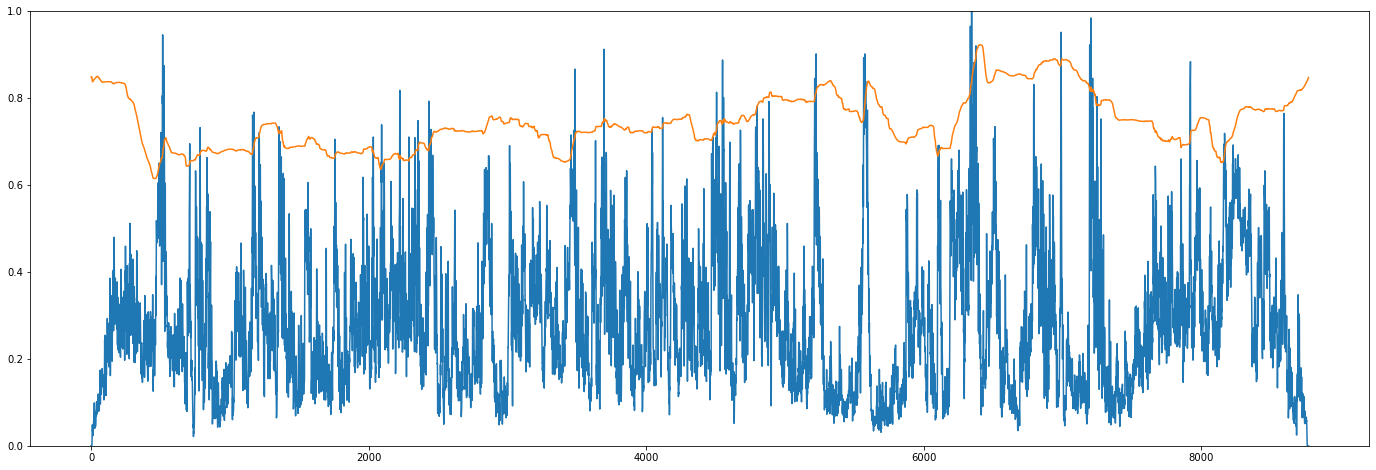

In [7]:
# Intensity (in generally)
feature = librosa.stft(audio, n_fft=2048)

feature = np.abs(feature) ** 2 # power spectrogram
intensity = np.sum(feature, axis=0)

max_intensity = 1.0
min_intensity = -1.0

max_value = np.max(np.abs(intensity))

if max_value > 0 :
    intensity = intensity * (max_intensity / max_value)
    
print(intensity)
print(intensity.shape)

thresholds = get_adaptive_threshold(intensity)

plt.figure(figsize=(24, 8))
plt.ylim(0, 1)
plt.plot(intensity)
plt.plot(thresholds)

(8775,)
(8775,)
(8775,)
(8775,)


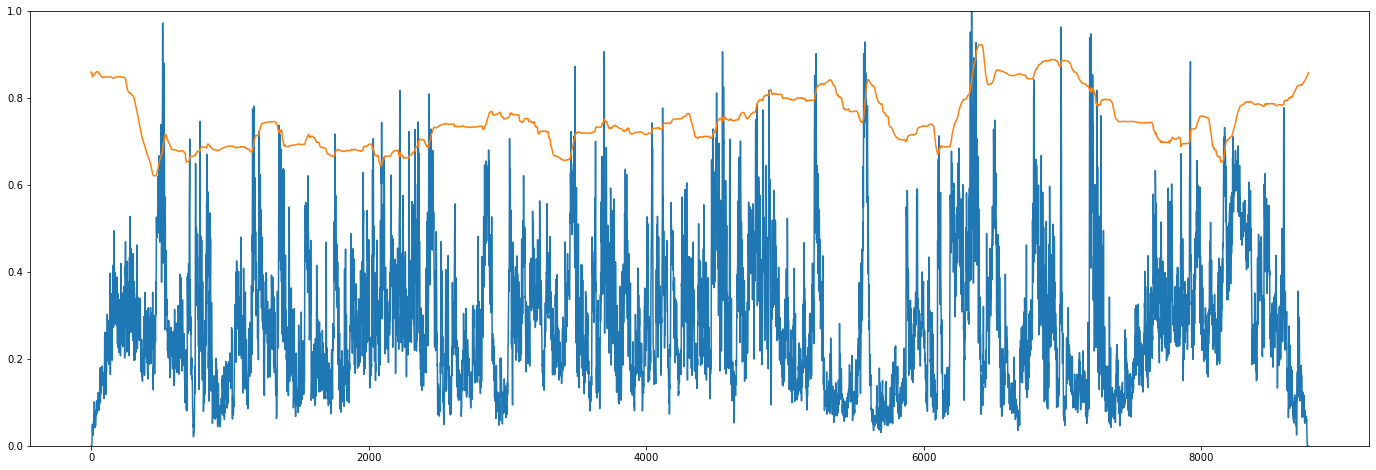

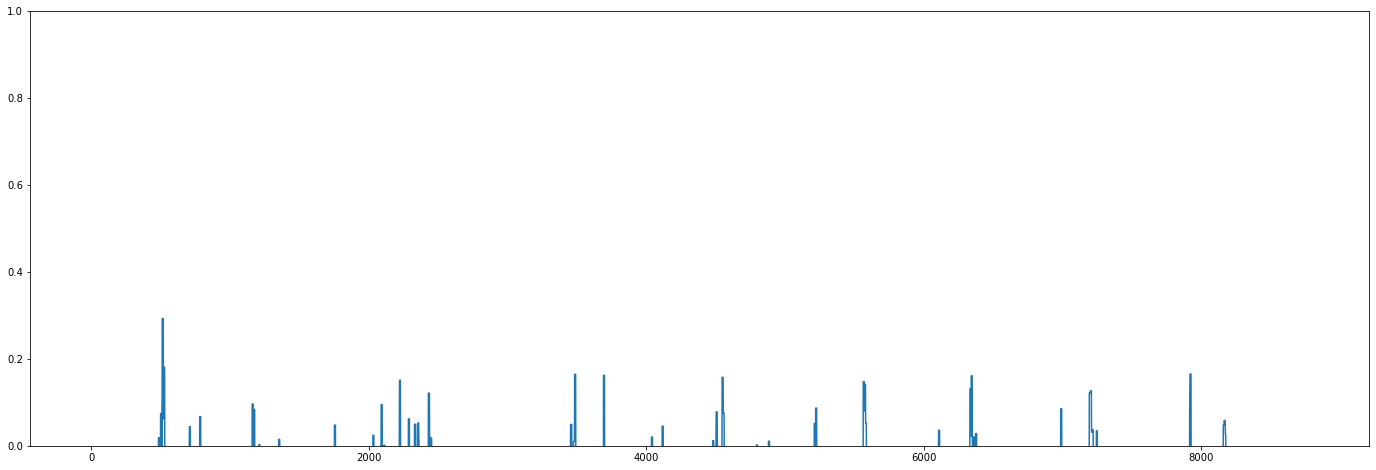

In [9]:
# Loudness
n_fft = 2048 # hop_length = n_fft // 4
frequency_range = (26, 9240)

feature = librosa.stft(audio, n_fft=n_fft)

# 주파수 범위 선택
freq_bins = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
freq_indices = np.where((freq_bins >= frequency_range[0]) & (freq_bins <= frequency_range[1]))[0]
feature = feature[freq_indices, :]

weight_factor = 1
loudness = feature * weight_factor * 20

loudness = np.abs(loudness) ** 2 # power of loudness
loudness = np.sum(loudness, axis=0)

max_loudness = 1.0
min_loudness = -1.0
max_value = np.max(np.abs(loudness))

if max_value > 0:
    loudness = loudness * (max_loudness / max_value)

print(loudness.shape)

# thresholds 계산
thresholds = get_adaptive_threshold(loudness)
print(thresholds.shape)

# threshold 를 상회하는 값 loudness_result 계산
loudness_result = loudness - thresholds
print(loudness_result.shape)

# max window function 적용
window_time_length = 0.1 # 0.1초만큼 window 자르기
window_size = get_index_from_time(window_time_length)
window_size_divided = window_size // 2
loudness_result = np.array([ np.max(loudness_result[(i-window_size_divided if i-window_size_divided >= 0 else 0):(i+window_size_divided if i+window_size_divided < len(loudness_result) else len(loudness_result))]) for i in range(0, len(loudness_result)) ])
loudness_result[np.isnan(loudness_result)] = 0
print(loudness_result.shape)

# 그래프 출력
plt.figure(figsize=(24, 8))
plt.ylim(0, 1)
plt.plot(loudness)
plt.plot(thresholds)
plt.figure(figsize=(24, 8))
plt.ylim(0, 1)
plt.plot(loudness_result)

C:\Users\devtae\AppData\Local\Temp/ipykernel_29964/2486835830.py:22: RuntimeWarning: invalid value encountered in true_divide
  sharpness = sharpness / loudness


(8775,)
(8775,)
(8775,)
(8775,)


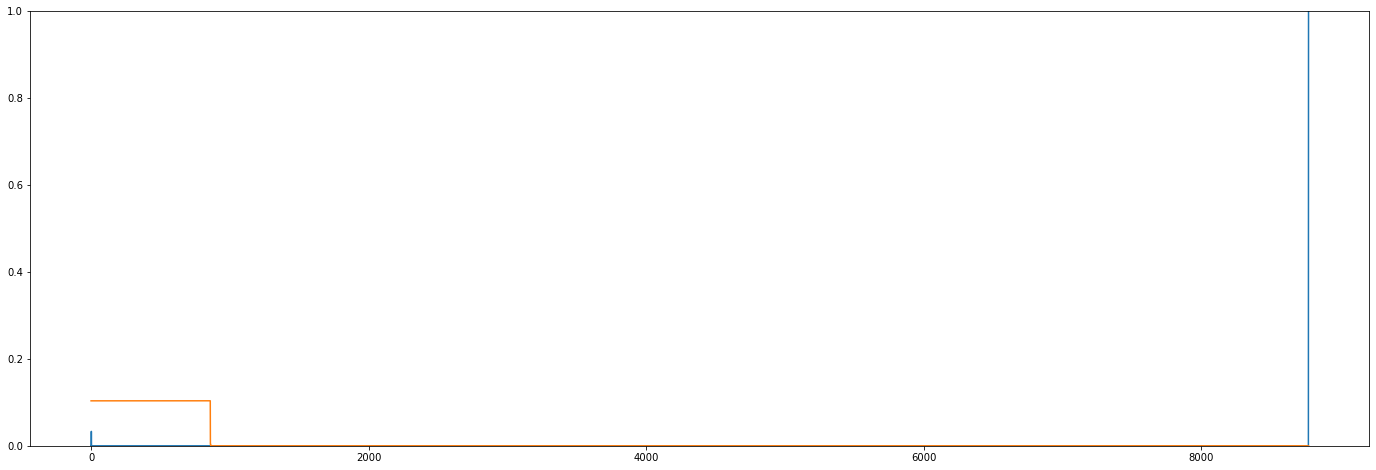

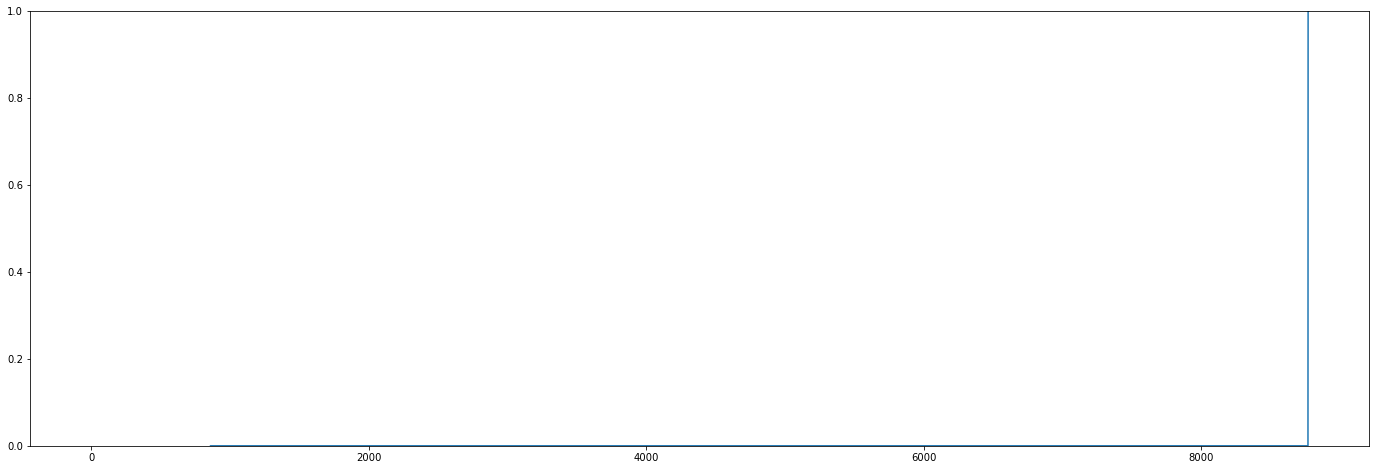

In [45]:
# Sharpness
n_fft = 2048 # hop_length = n_fft // 4
frequency_range = (26, 9240)

feature = librosa.stft(audio, n_fft=n_fft)

# 주파수 범위 선택
freq_bins = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
freq_indices = np.where((freq_bins >= frequency_range[0]) & (freq_bins <= frequency_range[1]))[0]
feature = feature[freq_indices, :]

# A-weighting 적용
a_weighting = librosa.A_weighting(freq_bins) # 각각의 frequency 들에 대하여 A-weighting 적용
# a_weighting[freq_indices, np.newaxis]

tmp = np.array([])

for idx, item in enumerate(freq_indices):
    tmp = np.append(tmp, a_weighting[item] * item)

sharpness = 0.11 * feature * weight_factor * 20 * tmp[:, np.newaxis]
sharpness = np.abs(sharpness) ** 2 # power of loudness
sharpness = sharpness / loudness
sharpness[np.isnan(sharpness)] = 0
sharpness = np.sum(sharpness, axis=0)

max_sharpness = 1.0
min_sharpness = -1.0
max_value = np.max(np.abs(sharpness))

if max_value > 0:
    sharpness = sharpness * (max_sharpness / max_value)

print(sharpness.shape)

# thresholds 계산
thresholds = get_adaptive_threshold(sharpness)
print(thresholds.shape)

# threshold 를 상회하는 값 sharpness_result 계산
sharpness_result = sharpness - thresholds
print(sharpness_result.shape)

# max window function 적용
window_time_length = 0.1 # 0.1초만큼 window 자르기
window_size = get_index_from_time(window_time_length)
window_size_divided = window_size // 2
sharpness_result = np.array([ np.max(sharpness_result[(i-window_size_divided if i-window_size_divided >= 0 else 0):(i+window_size_divided if i+window_size_divided < len(sharpness_result) else len(sharpness_result))]) for i in range(0, len(sharpness_result)) ])
sharpness_result[np.isnan(sharpness_result)] = 0
print(sharpness_result.shape)

# 그래프 출력
plt.figure(figsize=(24, 8))
plt.ylim(0, 1)
plt.plot(sharpness)
plt.plot(thresholds)
plt.figure(figsize=(24, 8))
plt.ylim(0, 1)
plt.plot(sharpness_result)

In [21]:
# Booming

In [22]:
# 오디오 이벤트 계산
audio_events = list()

# loudness + booming + sharpness
cognition_result = loudness_result # 일단 loudness_result 만 반영
cognition_ratio = [ (1, 0, 0) for _ in loudness_result ] # 세 가지 피쳐에 대한 비율 (추후에 반영)

i = 0
while i < len(cognition_result):
    if cognition_result[i] >= 0 and cognition_result[i-1] < 0:
        start_index = i
        end_index = None
        start_time = round(get_time_from_index(i), 2)
        end_time = None
        
        # 지속기간 계산
        for j in range(i, len(cognition_result)):
            if cognition_result[j] < 0:
                end_index = j
                end_time = round(get_time_from_index(j), 2)
                break

        # 진동 타입 정의
        haptic_type = get_haptic_type(cognition_ratio[start_index:end_index])
        
        # 진동 세기 정의
        haptic_level = get_haptic_level(cognition_result[start_index:end_index], cognition_ratio[start_index:end_index])
        
        # 지속시간 정의
        duration = round(end_time - start_time, 2)
        
        print("[Event Detector]", start_time, "초에", haptic_type, "타입에 대하여", haptic_level, "단계의 이벤트가", duration, "초동안 감지되었습니다.")
        audio_events.append((haptic_type, start_time, haptic_level, duration))
        
    i += 1

[Event Detector] 5.82 초에 default 타입에 대하여 1 단계의 이벤트가 0.45 초동안 감지되었습니다.
[Event Detector] 8.22 초에 default 타입에 대하여 1 단계의 이벤트가 0.09 초동안 감지되었습니다.
[Event Detector] 8.71 초에 default 타입에 대하여 1 단계의 이벤트가 0.25 초동안 감지되었습니다.
[Event Detector] 9.04 초에 default 타입에 대하여 1 단계의 이벤트가 0.27 초동안 감지되었습니다.
[Event Detector] 9.66 초에 default 타입에 대하여 1 단계의 이벤트가 0.16 초동안 감지되었습니다.
[Event Detector] 9.9 초에 default 타입에 대하여 1 단계의 이벤트가 0.14 초동안 감지되었습니다.
[Event Detector] 13.56 초에 default 타입에 대하여 1 단계의 이벤트가 0.14 초동안 감지되었습니다.
[Event Detector] 14.04 초에 default 타입에 대하여 1 단계의 이벤트가 0.1 초동안 감지되었습니다.
[Event Detector] 15.69 초에 default 타입에 대하여 1 단계의 이벤트가 0.1 초동안 감지되었습니다.
[Event Detector] 15.86 초에 default 타입에 대하여 1 단계의 이벤트가 0.12 초동안 감지되었습니다.
[Event Detector] 16.04 초에 default 타입에 대하여 1 단계의 이벤트가 0.14 초동안 감지되었습니다.
[Event Detector] 20.36 초에 default 타입에 대하여 1 단계의 이벤트가 0.1 초동안 감지되었습니다.
[Event Detector] 21.25 초에 default 타입에 대하여 1 단계의 이벤트가 0.1 초동안 감지되었습니다.
[Event Detector] 22.77 초에 default 타입에 대하여 1 단계의 이벤트가 0.09 초동안 감지되었습니다.
[Event Detector] 

In [23]:
# 오디오 이벤트 파일로 저장
with open(file_name.replace(".mp3", ".txt"), "w") as f:
    for (haptic_type, start_time, haptic_level, duration) in audio_events:
        f.write(str(haptic_type) + "," + str(start_time) + "," + str(haptic_level) + "," + str(duration) + "\n")